In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
import datetime
import numpy as np

## 1. Reading the dataset

In [8]:
chicago = pd.read_csv("Crimes_-_2001_to_present.csv")
ch_10 = chicago[chicago.Year > 2007]

### Looking at the Top Crimes

In [9]:
top_10_crimes = ch_10['Primary Type'].value_counts()[0:10].index
top_5_crimes = ch_10['Primary Type'].value_counts()[0:7].index
top_5_crimes = [each for each in top_5_crimes if 'OTHER' not in each]

In [10]:
ch_top10 = ch_10[ch_10['Primary Type'].isin(top_10_crimes)]

In [11]:
ch_top10.loc[:,'Month']  = ch_top10.Date.apply(lambda x: x[0:2])
ch_top10.loc[:,'Day']  = ch_top10.Date.apply(lambda x: x[3:5])
ch_top10.loc[:,'Yr']  = ch_top10.Date.apply(lambda x: x[6:10])

ch_top10.loc[:,'Hour'] = ch_top10.Date.apply(lambda x: x[11:13])
ch_top10.loc[:,'Minute'] = ch_top10.Date.apply(lambda x: x[14:16])
ch_top10.loc[:,'AM_PM'] = ch_top10.Date.apply(lambda x: x[-2:])

C:\Users\arvra\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\arvra\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
crimes = ch_top10.groupby(['Yr','Month','Day'],as_index = False)['ID'].count()
crimes.loc[:,'Date'] = crimes.iloc[:,:3].apply(lambda x: '-'.join(x),axis = 1)

In [13]:
mean = crimes[crimes.Yr != '2019'].groupby(['Yr'])['ID'].mean()
mean_shift = crimes[crimes.Yr != '2019'].groupby(['Yr'])['ID'].mean().shift(1)

(100 * (mean - mean_shift)/mean_shift).mean()

-4.589659862555443

In [14]:
## Adjusting the plot size
plt.rcParams["figure.figsize"] = [15,10]

### Plotting the crime trend for the last 10 years

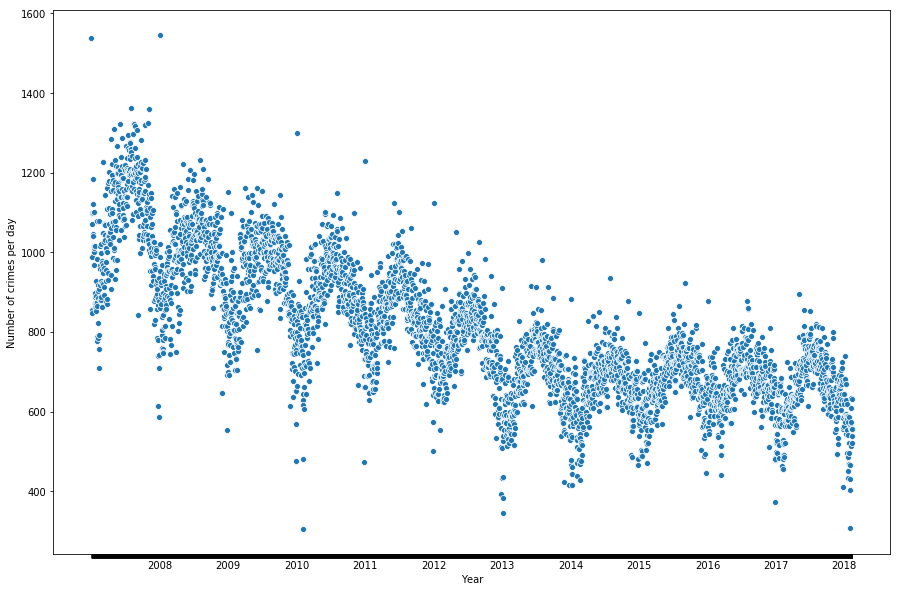

In [15]:
## Data for plotting
crimes_plot = crimes.loc[crimes.Yr.astype(int) > 2005,]

ax = sns.scatterplot(x="Date", y="ID",
                      #palette="Set2",
                      data=crimes_plot)
lab = ["" if crimes_plot.Yr[val+1] == each else each for val,each in enumerate(crimes_plot.Yr[:-1])]
_ = ax.set_xticklabels(lab)
_ = ax.set(xlabel='Year', ylabel='Number of crimes per day')

### Analyzing top crimes acorss years

In [16]:
#### Selecting only the top 5 crimes for growth analysis
ch_top5 = ch_top10[ch_top10['Primary Type'].isin(top_5_crimes)]

crime_yrs = ch_top5[~ch_top5.Year.isin([2019])].groupby(['Year','Month','Primary Type'],as_index = False)['ID'].count()

In [17]:
crime_yrs.loc[:,'Year_month'] = crime_yrs.loc[:,['Year','Month']].apply(lambda x: str(x[0])+"_"+str(x[1]),axis = 1)

C:\Users\arvra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


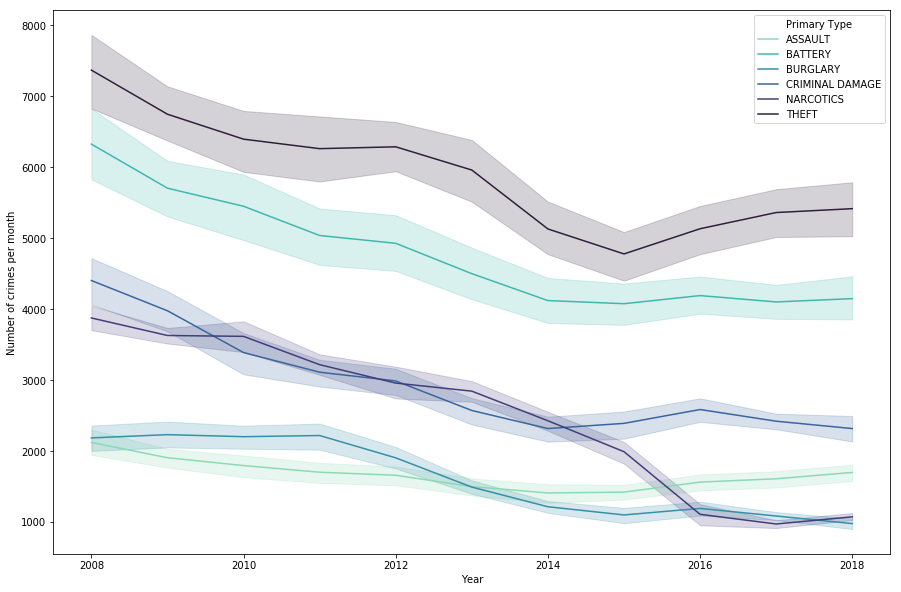

In [18]:
total_crimes = len(crime_yrs['Primary Type'].unique())

palette = sns.color_palette("mako_r", total_crimes)
ax_line = sns.lineplot(x="Year", y="ID",
                   hue="Primary Type",
                   palette=palette, data=crime_yrs)
lab = ["" if crimes_plot.Yr[val+1] == each else each for val,each in enumerate(crimes_plot.Yr[:-1])]
_ = ax_line.set(xlabel='Year', ylabel='Number of crimes per month')

### Proportion of Top 6 crimes out of the total crimes

In [36]:
crime_contribution = 100 * ch_10[ch_10.Year == 2018]['Primary Type'].value_counts()/sum(ch_10[ch_10.Year == 2018]['Primary Type'].value_counts())

In [37]:
crime_contribution[0:10]

THEFT                  24.464569
BATTERY                18.736873
CRIMINAL DAMAGE        10.462823
ASSAULT                 7.668421
DECEPTIVE PRACTICE      6.947612
OTHER OFFENSE           6.429308
NARCOTICS               4.842401
BURGLARY                4.411422
MOTOR VEHICLE THEFT     3.761753
ROBBERY                 3.646574
Name: Primary Type, dtype: float64

In [38]:
crime_contribution[0:5].sum() + crime_contribution[7]

72.69171992742986

### Crime Rates in Top US cities

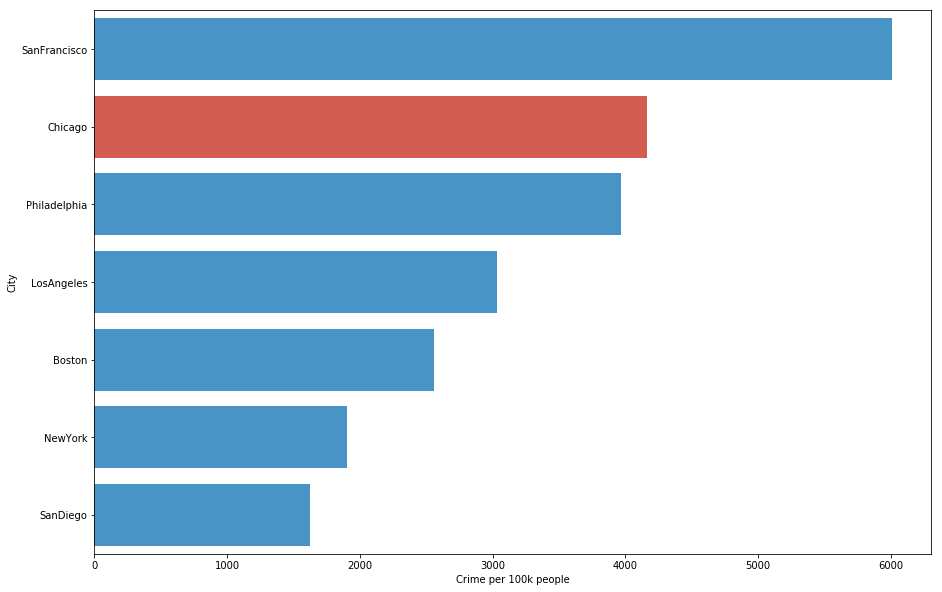

In [39]:
## Reading the text file with specific column names
crime_rate = pd.read_table('crime rate.txt', delim_whitespace=True,encoding = 'utf-8', \
                           names = ('City','Crime_1990','Crime_2017','Crime_2018','Change'))

## Creating an integer column for Crime 2018
crime_rate['Crime_2018_int'] = pd.to_numeric(crime_rate.Crime_2018.str.replace(",",""),errors='coerce')

largest_cities = ['SanFrancisco','Chicago','NewYork','LosAngeles','Philadelphia','Boston','SanDiego']

crime_bar = crime_rate[crime_rate.City.isin(largest_cities)].sort_values(['Crime_2018_int'],ascending = False)
color_bar = ['#3498db' if each != 'Chicago' else '#e74c3c' for each in crime_bar.City]


#### Plotting the Chart
ax_city = sns.barplot(x = "Crime_2018_int", y = "City", 
            data = crime_rate[crime_rate.City.isin(largest_cities)].sort_values(['Crime_2018_int'],ascending = False),
            #palette = 'muted',
            palette =  color_bar)

_ = ax_city.set(xlabel='Crime per 100k people', ylabel='City')

### _Although the overall trends of crimes seem to go down, Chicago still has higher crime rate than some of the largest US cities_

## How should the crimes be reduced?

#### Focus area: Seeking answers to,
#### What? Where? When?

### 1. What crime to focus?

### Crimes with highest growth rate over the last few years

In [41]:
### Removing 2019 from the analysis since the year is incomplete
crime_yrs = ch_top10[~ch_top10.Year.isin([2019])].\
            groupby(['Year','Primary Type'],as_index = False)['ID'].count().\
            sort_values(['Primary Type','Year'])

### Calculating the growth for each of the top crimes
crime_yrs['Prev_year'] = crime_yrs.groupby(['Primary Type'])['ID'].shift(1)
crime_yrs['Growth'] = 100 * (crime_yrs.ID - crime_yrs.Prev_year)/(crime_yrs.Prev_year)


## Getting the average growth for these crimes for the last 4-5 years
avg_growth = crime_yrs[crime_yrs.Year.isin(range(crime_yrs.Year.max()-4,crime_yrs.Year.max()+1))].\
             groupby(['Primary Type'],as_index= False)['Growth'].mean()

### Creating a final data frame with two growth rates - latest year growth vs. growth over last 5 years
avg_growth = pd.DataFrame(avg_growth)
avg_growth.columns = ['Primary Type','Average_Growth_5_years']

top_crimes_analysis = pd.merge(crime_yrs[crime_yrs.Year == 2018],avg_growth,on = ['Primary Type'])
top_crimes_analysis['Total Crimes - 2018'] = pd.to_numeric(top_crimes_analysis.ID)

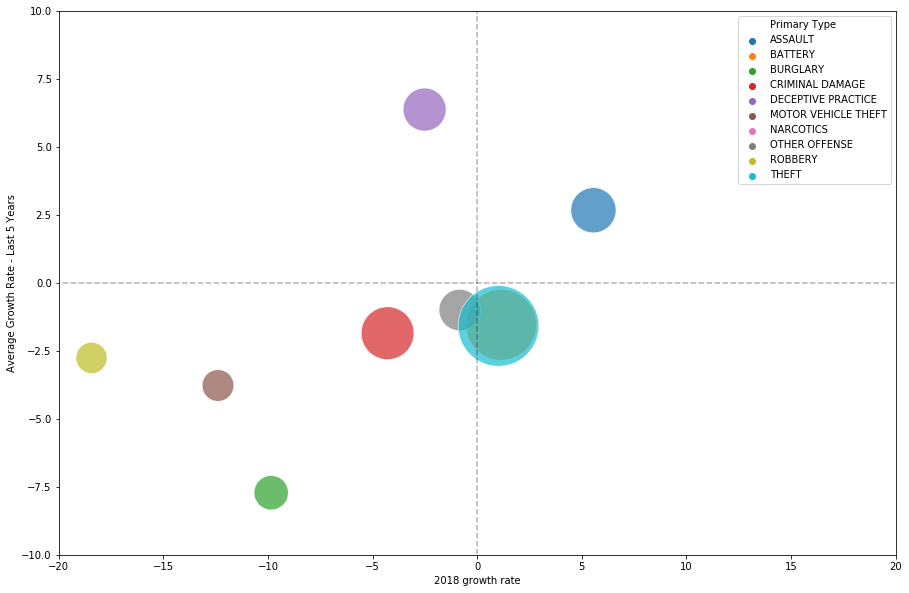

In [42]:
ax_growth = sns.scatterplot(x="Growth", y="Average_Growth_5_years",
                       s= top_crimes_analysis.ID.values * 0.1, hue = 'Primary Type',
                       alpha = 0.7,
                       data=top_crimes_analysis)
                       #palette = 'muted')
axes = ax_growth.axes
_ = ax_growth.set(xlabel='2018 growth rate', ylabel='Average Growth Rate - Last 5 Years')

axes.set_ylim(-10,10)
axes.set_xlim(-20,20)

plt.plot(range(-30,30),[0] * len(range(-30,30)),color = 'black',ls = '--',alpha = 0.3)
plt.plot([0] * len(range(-30,30)),range(-30,30),color = 'black',ls = '--',alpha = 0.3)

### Which location to focus?

#### Visualizing Geo-spatial data

In [43]:
### Selecting the year 2018 
ch_2018 = ch_top10[ch_top10.Year.isin([2018])]

### Removing the NA values
ch_2018 = ch_2018[~ch_2018['X Coordinate'].isna()]

In [44]:
lat_long = ch_2018.loc[:,['Latitude','Longitude']][:1000]
lat_long['val'] = 1
lat_long_count = lat_long.groupby(['Latitude','Longitude'],as_index=False)['val'].count()
lat_long_matrix = lat_long_count.as_matrix()

In [45]:
# lat_long = ch_2018.loc[:,['Latitude','Longitude']][:10000]

# lat_long_round = lat_long.apply(lambda x: round(x,2))
# lat_long_round['count'] = 1
# result = lat_long_round.groupby(['Latitude','Longitude'],as_index=False)['count'].count()
# result = result.as_matrix()

In [46]:
lat_long = ch_2018.loc[:,['Community Area']][:100000]

lat_long_round = lat_long.apply(lambda x: round(x,2))
lat_long_round['count'] = 1
ward_map = lat_long_round.groupby(['Community Area'],as_index=False)['count'].count()
ward_map.loc[:,'Community Area'] = ward_map['Community Area'].astype(int)
ward_map = ward_map.sort_values(['count'],ascending = True)

#### Reading Community Area zip code map

In [47]:
community_zip = pd.read_csv("community_zip.csv")

In [48]:
zip_counts = pd.merge(ward_map,community_zip,how = 'outer',left_on = 'Community Area',right_on='community')
zip_counts_group = zip_counts.groupby(['zip'],as_index=False)['count'].sum()
zip_counts_group.zip = zip_counts_group.zip.astype(int).astype(str)

In [5]:
m = folium.Map([41.8781, -87.6298], zoom_start=10)

m.choropleth(geo_data ='zipcodes2.geojson.txt', data=zip_counts_group,
             columns=['zip', 'count'],
             key_on='feature.properties.ZIP',
             threshold_scale=[0,500,1000,3000,5000,6000,7000,8000,10000,40000],
             fill_opacity = 0.6,
             fill_color='BuPu',
            highlight = True)
m

In [102]:
m = folium.Map([41.8781, -87.6298], zoom_start=10)
plugins.HeatMap(lat_long_matrix,min_opacity =0.45,max_val = 0.7,radius = 20).add_to(m)
m

In [103]:
m = folium.Map([41.8781, -87.6298], zoom_start=10)
plugins.MarkerCluster(lat_long_matrix).add_to(m)
m

### What times to be alert?

In [240]:
## Treating the NA values - Replace the NA in districts by taking the majortiy of the
# district belong to that particular Ward-Community Area Combination

### Getting the weekday

In [91]:
#### Creating a column with Date object
Date_time = ch_top10.loc[:,['Yr','Month','Day']].apply(
                                    lambda x:datetime.datetime(int(x[0]),int(x[1]),int(x[2])),axis = 1)

#### Creating a weekday column
ch_top10.loc[:,'Date_time'] = Date_time
ch_top10.loc[:,'Weekday'] = ch_top10.Date_time.apply(lambda x: x.weekday())


### Converting the 12-hour time to 24-hour format
time_24 = np.where((ch_top10.AM_PM == 'PM') & (ch_top10.Hour.astype(int) != 12),
                 ch_top10.Hour.astype(int)+12,ch_top10.Hour.astype(int))

time_24 = np.where((ch_top10.AM_PM == 'AM') & (time_24 == 12),0,time_24)

ch_top10.loc[:,'Hour_24'] = time_24

### Weekday Hour Heat Map

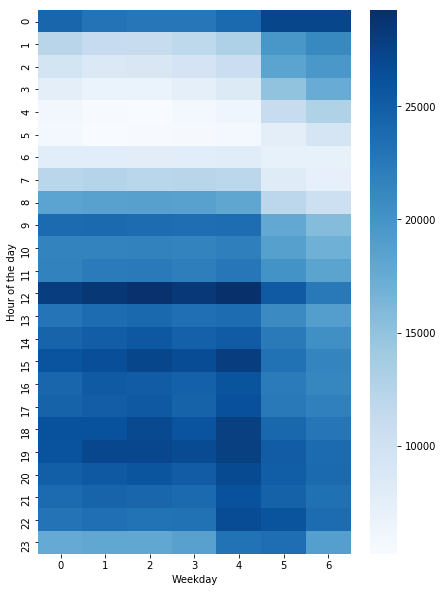

In [104]:
hour_by_week = ch_top10.pivot_table(values='ID', index=ch_top10.Hour_24,
                                    columns=ch_top10.Weekday, aggfunc=np.size).fillna(0)

plt.figure(figsize = (7,10))
ax_hour = sns.heatmap(hour_by_week, cmap="Blues")
_ = ax_hour.set(xlabel='Weekday', ylabel='Hour of the day')

### Year Month Heat Map

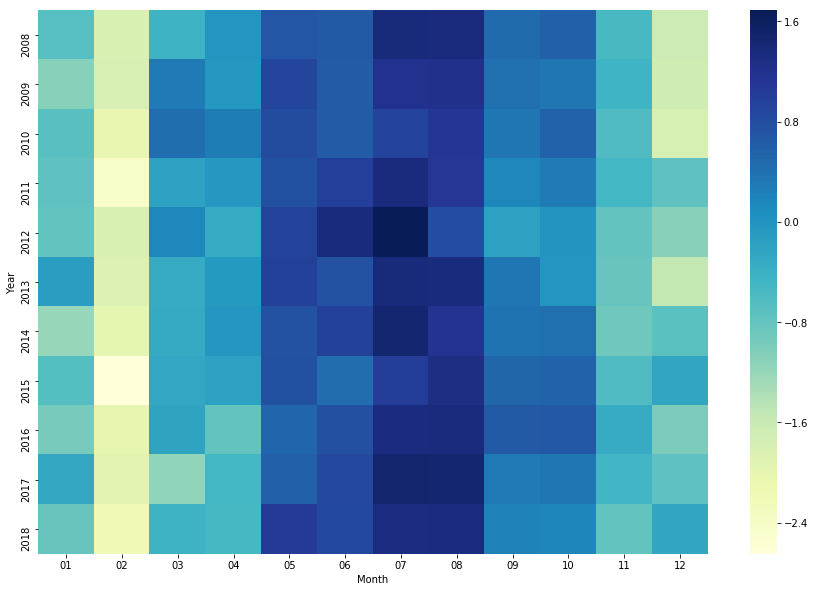

In [105]:
year_month = ch_top10.pivot_table(values='ID', index=ch_top10.Yr,
                                    columns=ch_top10.Month, aggfunc=np.size).fillna(0)
year_month = year_month[year_month.index != '2019']
yr_mn = year_month.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 1)

ax_month = sns.heatmap(yr_mn, cmap="YlGnBu")
_ = ax_month.set(xlabel='Month', ylabel='Year')

### Crime Type - Day Heat Map

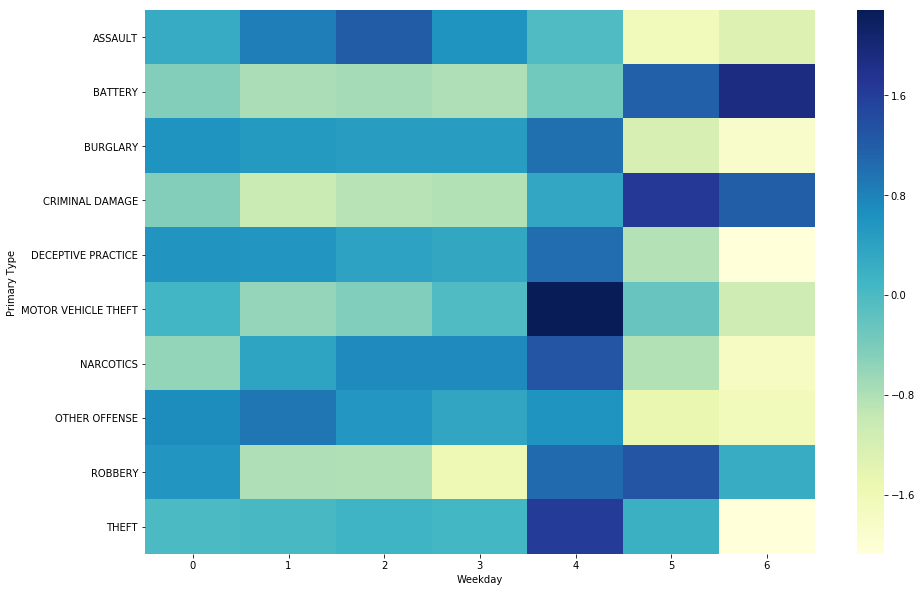

In [372]:
crime_day = ch_top10.pivot_table(values='ID', index=ch_top10['Primary Type'],
                                    columns=ch_top10.Weekday, aggfunc=np.size).fillna(0)
crime_day = crime_day[crime_day.index != '2019']

crime_day_std = crime_day.apply(lambda x: (x - np.mean(x))/np.std(x),axis = 1)

sns.heatmap(crime_day_std, cmap="YlGnBu")